In [1]:
import psycopg2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import dotenv
import numpy as np
import random
from datetime import datetime, timezone

In [2]:
dotenv.load_dotenv('.env', override=True)

# Connect to DB
conn = psycopg2.connect(
    f"dbname='{os.environ['POSTGRES_DB']}' user='{os.environ['POSTGRES_USER']}' "
    f"host='{os.environ['POSTGRES_HOST']}' password='{os.environ['POSTGRES_PASSWORD']}'"
)

In [3]:
from_date = "2024-10-30 20:00:00"
to_date = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

In [4]:
def showTracksInArea(left, right, top, bottom, from_date=None, to_date=None, show_names=True, title="", speed_limit=1, width_limit=1, resolution="f"):
    random.seed(1)

    if to_date is None:
        to_date = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

    # Get ship data
    with conn.cursor() as cursor:
        if from_date:
            cursor.execute(f"""
                SELECT ships.name, ships.id, location[0] AS latitude, location[1] AS longitude
                FROM positions
                JOIN ships ON positions.ship_id = ships.id
                WHERE positions.location[0] BETWEEN {bottom} AND {top}
                AND positions.location[1] BETWEEN {left} AND {right}
                AND ships.width > {width_limit}
                AND positions.speed > {speed_limit}
                AND positions.parsed_date > '{from_date}'::timestamp
                AND positions.parsed_date <= '{to_date}'::timestamp
                ORDER BY ships.name, positions.parsed_date
            """)
        else:
            cursor.execute(f"""
                SELECT ships.name, ships.id, location[0] AS latitude, location[1] AS longitude
                FROM positions
                JOIN ships ON positions.ship_id = ships.id
                positions.location[0] BETWEEN {bottom} AND {top}
                AND positions.location[1] BETWEEN {left} AND {right}
                AND ships.width > {width_limit}
                AND positions.speed > {speed_limit}
                AND positions.parsed_date > '{from_date}'::timestamp
                AND positions.parsed_date <= '{to_date}'::timestamp
                ORDER BY ships.name, positions.parsed_date
            """)
        data = cursor.fetchall()

    # Sort ships
    ship_data = {}
    ship_names = {}
    for row in data:
        name, id, lat, lon = row
        if id not in ship_data:
            ship_data[id] = {'lats': [], 'lons': []}
            ship_names[id] = name
        ship_data[id]['lats'].append(lat)
        ship_data[id]['lons'].append(lon)

    # Render landscape
    plt.figure(figsize=(12, 10))

    m = Basemap(projection='merc',
                llcrnrlat=bottom, urcrnrlat=top,
                llcrnrlon=left, urcrnrlon=right,
                resolution=resolution)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgreen', lake_color='aqua')

    map_width_km = 0.1 * abs(right - left) * 111
    scale_length = max(round(map_width_km, -1), 5)

    m.drawmapscale(
        right - 0.2 * abs(right - left),
        bottom + 0.1 * abs(top - bottom),
        left, top,
        length=scale_length,
        barstyle='fancy', labelstyle='simple', units='km', fontsize=6
    )

    # Show ships tracks
    for id, ship_info in ship_data.items():
        color = (random.random(), random.random(), random.random())
        x, y = m(ship_info['lons'], ship_info['lats'])

        m.plot(x, y, marker='x', markersize=2, linewidth=1, color=color)

        if show_names:
            plt.text(x[len(x) - 1], y[len(y) - 1], f'{ship_names[id]}',
                     fontsize=6, color='darkred', ha='right')

    plt.text(0.01, 0.98, f'Area: {top}, {left}; {right}, {bottom}\nNumber of tracks: {len(ship_names)}\nTrack points: {len(data)}\nTime range: {from_date} - {to_date}',
             fontsize=8, color='black', ha='left', va="top", transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.title(f"Tracks of Ships in {title}")
    plt.show()

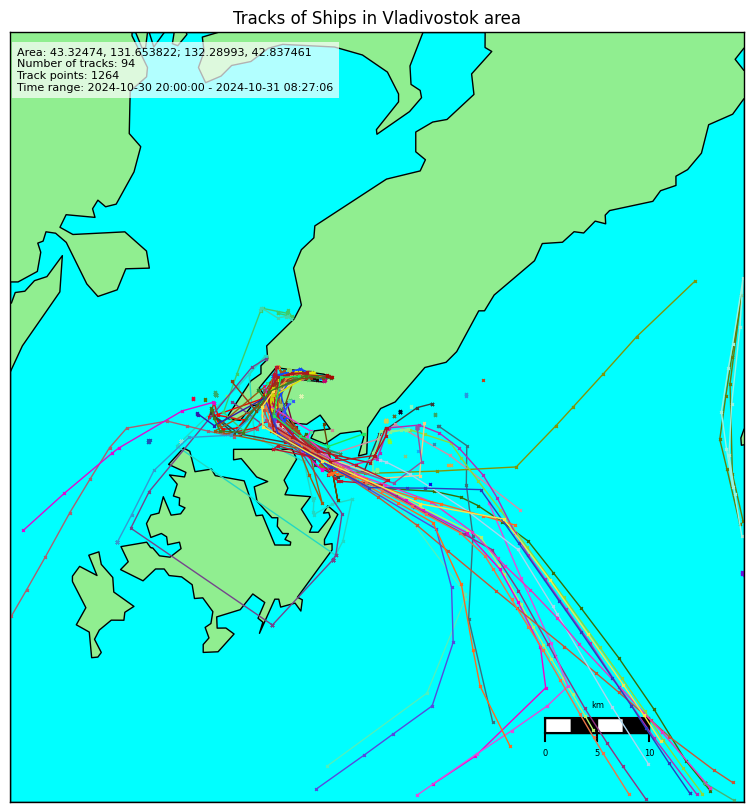

In [5]:
showTracksInArea(131.653822, 132.289930, 43.324740, 42.837461,
                 from_date=from_date, to_date=to_date, title="Vladivostok area", show_names=False, resolution="h")

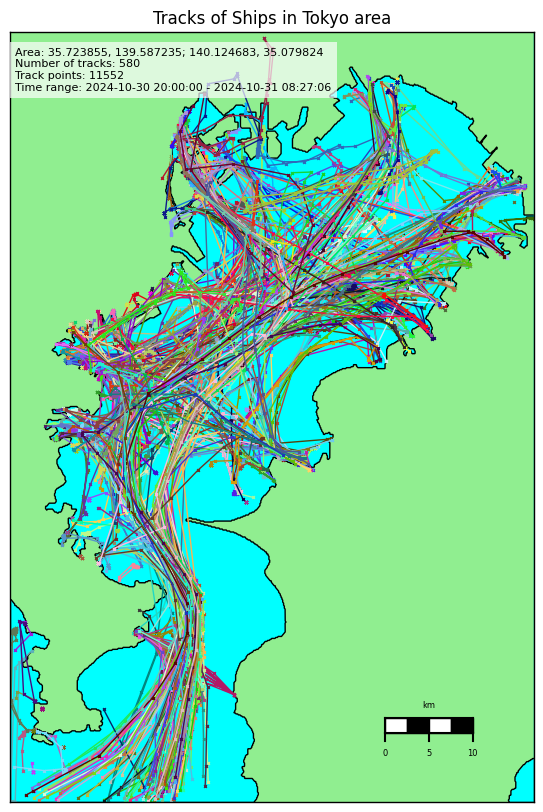

In [7]:
showTracksInArea(139.587235, 140.124683, 35.723855, 35.079824,
                 from_date=from_date, to_date=to_date, title="Tokyo area", show_names=False)

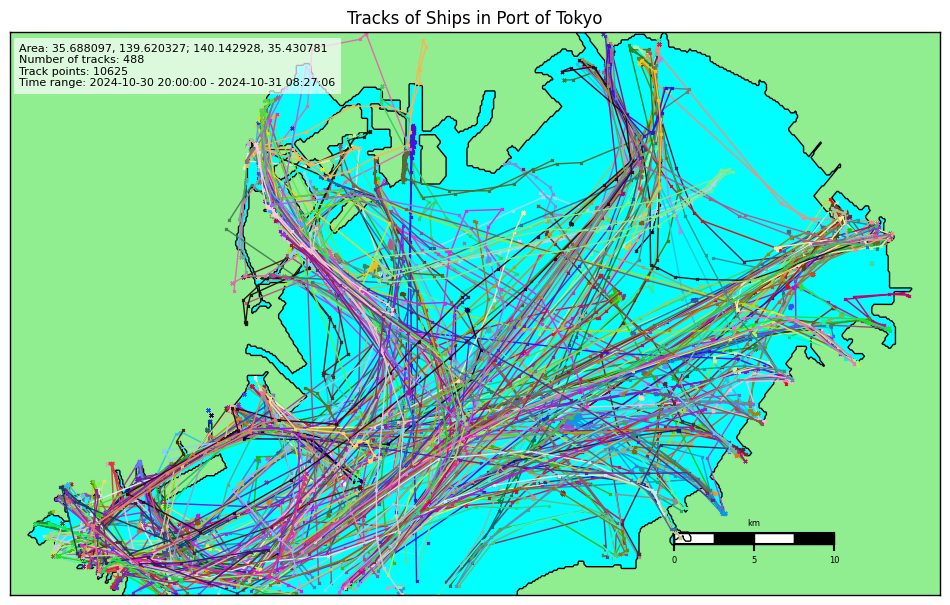

In [8]:
showTracksInArea(139.620327, 140.142928, 35.688097, 35.430781, from_date=from_date,
                 to_date=to_date, title="Port of Tokyo", show_names=False, speed_limit=0)

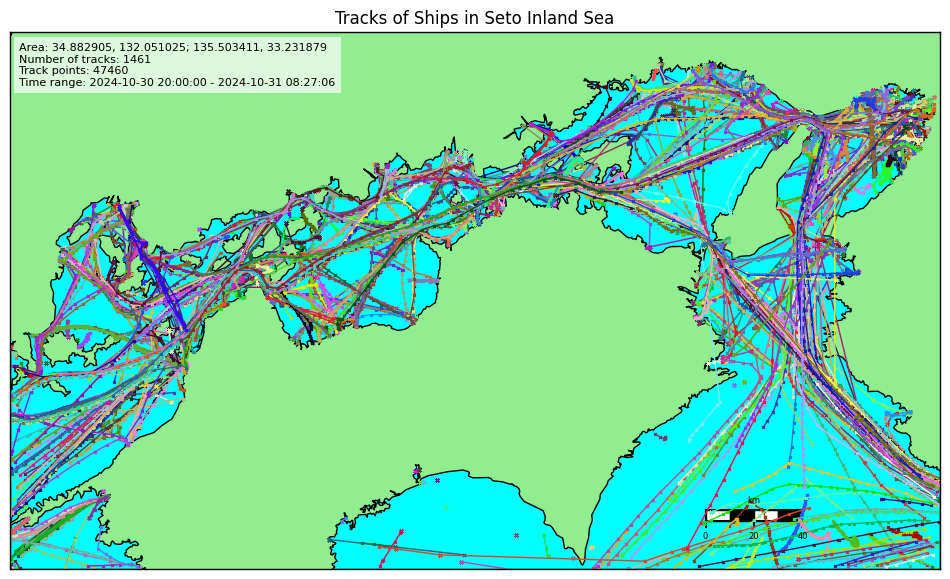

In [9]:
showTracksInArea(132.051025, 135.503411, 34.882905, 33.231879, from_date=from_date,
                 to_date=to_date, title="Seto Inland Sea", show_names=False, resolution="h")